In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sb

## Display information

In [2]:
names = ['userid', 'itemid', 'rating', 'timestamp']
raw_data = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)

print('Count of ratings', len(raw_data))
print('First ten rows')
print(raw_data[0:10])

# save data in a numpy array where each user ratings have their own rows
userids = sorted(list(raw_data['userid'].unique()))
itemids = sorted(list(raw_data['itemid'].unique()))

# first save in list of lists, use None values if user has not rated item
data = [[None] * len(userids) for x in range(len(itemids))]

# find ratings made by each user
for i in range(len(itemids)):
    # dict of ratings for item i+1 (key = userid, value = rating)
    item_ratings = dict(zip(raw_data.loc[raw_data['itemid'] == (i+1)].userid, raw_data.loc[raw_data['itemid'] == (i+1)].rating))
    for j in range(len(userids)):
        # check if user has rated item with id j+1
        if j+1 in item_ratings:
            data[i][j] = item_ratings[j+1]

data = np.array(data)
print(data.shape)

Count of ratings 100000
First ten rows
   userid  itemid  rating  timestamp
0     196     242       3  881250949
1     186     302       3  891717742
2      22     377       1  878887116
3     244      51       2  880606923
4     166     346       1  886397596
5     298     474       4  884182806
6     115     265       2  881171488
7     253     465       5  891628467
8     305     451       3  886324817
9       6      86       3  883603013
(1682, 943)


In [3]:
# a = item a itemid, b = item b itemid, data = whole dataset
def cosine_similarity(a, b, data):
    # ratings for items a and b
    data_a = data[a-1] # indexing starts at one
    data_b = data[b-1]

    # dicts with userids and ratings
    dict_a = {u: r for u, r in enumerate(data_a, start=1) if r is not None}
    dict_b = {u: r for u, r in enumerate(data_b, start=1) if r is not None}

    # intersection between two sets
    P = list(set(dict_a).intersection(set(dict_b)))

    dict_a = {id: dict_a[id] for id in P}
    dict_b = {id: dict_b[id] for id in P}

    mean_a = np.mean(list(dict_a.values()))
    mean_b = np.mean(list(dict_b.values()))
    n = 0
    d1 = 0
    d2 = 0

    # calculate sums
    for userid in P:
        n += ((dict_a[userid] - mean_a) * (dict_b[userid] - mean_b))
        d1 += ((dict_a[userid] - mean_a) ** 2)
        d2 += ((dict_b[userid] - mean_b) ** 2)
    
    if n == 0:
        return 0

    sim = n / (np.sqrt(d1) * np.sqrt(d2))


    #scipy_sim = 1-spatial.distance.cosine(list(dict_a.values()), list(dict_b.values()))
    #if np.round(sim, 10) == np.round(scipy_sim, 10):
    #    print(sim, scipy_sim)
    #    print('all ok')
    #else:
    #    print(sim, scipy_sim)
    #    print("Not okay")
 
    return sim
cosine_similarity(567, 123, data)

-0.17518598317371087

### Similarity matrix of all items (makes calculations faster)

In [4]:
sim_matrix = [[1] * len(itemids) for x in range(len(itemids))]
for i in range(len(itemids)):
    for j in range(i+1, len(itemids)):
        sim_matrix[i][j] = sim_matrix[j][i] = cosine_similarity(i+1, j+1, data)

B:\Anaconda\envs\recommender\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
B:\Anaconda\envs\recommender\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


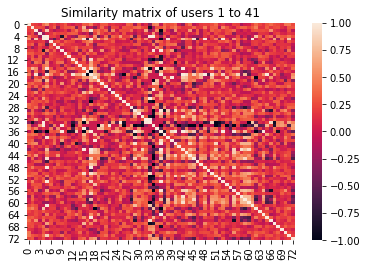

In [5]:
test_matrix = [[1] * int(len(itemids)/23) for x in range(int(len(itemids)/23))]
for i in range(int(len(itemids)/23)):
    for j in range(i+1, int(len(itemids)/23)):
        test_matrix[i][j] = test_matrix[j][i] = cosine_similarity(i+1, j+1, data)

test_matrix = np.array(test_matrix)

# heatmap of the similarity matrix
sb.heatmap(test_matrix)
plt.title('Similarity matrix of users 1 to 71')
plt.show()

In [28]:
# u = userid, p = itemid, data = whole data set, sim = item similarity vector, n = number of neighbours
def cosine_predict(u, p, data, sim_matrix, N):
    sim = sim_matrix[p-1]
    # convert similarity list to dict where key is itemid and value its similarity with item p
    sim = {i: s for i, s in enumerate(sim, start=1)}

    # dict of items and ratings for user u
    user_rated_items = {}

    for itemid in sim:
        if data[itemid-1][u-1] != None:
            user_rated_items[itemid] = data[itemid-1][u-1]
    
    for itemid in itemids:
        if itemid not in user_rated_items:
            del sim[itemid]

    # sort similarities based on dict values and return n highest values
    sim = dict(sorted(sim.items(), key=lambda x: x[1], reverse=True))
    sim = dict(list(sim.items())[:N])

    n = 0
    d = 0

    # loop through neighbourhood
    for itemid in sim:
        n += sim[itemid] * user_rated_items[itemid]
        d += sim[itemid]

    # this happens if all values in sim are 0. This means that the N nearest items have a similarity of zero with item p
    if n == 0:
        return 0
        
    return n/d

## Recommended 20 movies for any given user

In [29]:
USER = 15
# neighbourhood size
N = 20

# find items the user has not rated
items = []
for itemid in range(len(itemids)):
    if data[itemid-1][USER-1] == None:
            items.append(itemid)

predictions = {}

for item in items:
    predictions[item] = cosine_predict(USER, item, data, sim_matrix, N)

# sort predictions and take 20 highest
most_relevant = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True))
df = pd.DataFrame(list(zip(list(most_relevant.keys()), list(most_relevant.values()))), columns=['itemid', 'rating pred'])[:20]
print(df)

15 0
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 127: 0, 137: 0, 148: 0, 181: 0, 220: 0, 222: 0}
15 314
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 127: 0, 137: 0, 148: 0, 181: 0, 220: 0, 222: 0}
15 437
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 127: 0, 137: 0, 148: 0, 181: 0, 220: 0, 222: 0}
15 439
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 127: 0, 137: 0, 148: 0, 181: 0, 220: 0, 222: 0}
15 599
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 127: 0, 137: 0, 148: 0, 181: 0, 220: 0, 222: 0}
15 643
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 0, 111: 0, 118: 0, 121: 0, 125: 0, 137: 0, 148: 0, 220: 0, 222: 0, 225: 0, 235: 0}
15 677
{1: 0, 7: 0, 9: 0, 13: 0, 14: 0, 15: 0, 18: 0, 20: 0, 25: 0, 50: 